### Learning overdispersion parameter in negative binomial model

In [3]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from scipy.special import loggamma, digamma
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr

np.random.seed(12345)

In [5]:
# Old negative binomial functions for synthetic data.

def poisson_rvs(mu):
    return scipy.stats.poisson.rvs(mu)

def negativebinomial_rvs(mu, kappa, n=1):
    n1 = kappa
    p = float(kappa) / (kappa + mu)
    return scipy.stats.nbinom.rvs(n1, p, 0, n)

def expected_cases(Rt, past_cases, serial_interval):
    if np.abs(sum(serial_interval) - 1) > 1e-6:
        raise ValueError("Serial interval does not sum to 1.")
    return Rt * np.dot(past_cases, serial_interval)

def next_cases(Rt, past_cases, serial_interval, kappa):
    expectation = expected_cases(Rt, past_cases, serial_interval)
    if kappa is None:
        return poisson_rvs(expectation)
    elif kappa < 0:
        return expectation
    elif kappa is not None:
        return negativebinomial_rvs(expectation, kappa)

def generate_case_series(Rt_series, past_cases, serial_interval, kappa=None):
    """
    kappa 
        inverse overdispersion. If set to <0, it returns the expectation of the process rather
        than realization of actual data.
    """
    n_past_cases = len(past_cases)
    if n_past_cases != len(serial_interval):
        raise ValueError("Past cases must be of same length as serial interval.")
    series_len = len(Rt_series)
    cases = np.zeros(series_len + n_past_cases)
    cases[:n_past_cases] = past_cases
    
    lambdas = np.zeros(series_len + n_past_cases)
    
    for i in range(series_len):
        new_case_index = i + n_past_cases
        historical_cases = cases[i:new_case_index]
        historical_cases_rev = historical_cases[::-1]
        cases[new_case_index] = next_cases(
            Rt_series[i], historical_cases_rev, serial_interval, kappa)[0]
        
        lambdas[new_case_index] = next_cases(
            Rt_series[i], historical_cases_rev, serial_interval, -1) / Rt_series[i]
        
    cases_post_past = cases[n_past_cases:]
    lambdas_post_past = lambdas[n_past_cases:]
    days = np.arange(1, len(cases_post_past) + 1)
    df = pd.DataFrame(
        {'day': days,
        'cases': cases_post_past,
        'Rt': Rt_series,
        'lambdas': lambdas_post_past})
    return df


The negative binomial model for cases arising at time $t$,
$$
I_t | I_1, \dots, I_{t-1} \sim \text{NB}(R_t\Lambda_t, \phi).
$$
has the following log-likelihood: 
$$
\mathcal{L}(R_t, \phi)= I_t \log(\phi) + I_t\log(\Lambda_t) + I_t\log(R_t) + \log(\Gamma(I_t+1/\phi)) - \left(\frac{1}{\phi} + I_t\right) \log( \phi \Lambda_t R_t + 1) - \log(\Gamma(1/\phi)) - \log(I_t!)
$$

Using the Fisher information matrix, the Cramer-Rao Lower Bound for $R_t$ is:
$$
\frac{R_t(1+\phi \Lambda_t R_t)}{\Lambda_t}
$$
We define the variance inflation ratio as the ratio of the variance for $R_t$ when inferred with the negative binomial to the variance when inferred with Poisson ($\phi=0$). In the following equation, $\hat{R}_t$ is the estimate of $R_t$ when using the Poisson model.
$$
\text{VIR}(\phi) = \frac{\frac{R_t(1 + \phi \Lambda_t R_t)}{\Lambda_t}}{\frac{\hat{R}_t}{\Lambda_t}} = \frac{R_t(1 + \phi \Lambda_t R_t)}{\hat{R}_t}
$$
Assuming $\hat{R}_t = R_t$ (the MLE for $R_t$ with either model is the same):
$$
\text{VIR}(\phi) = 1 + \phi \Lambda_t R_t.
$$
For all $\phi>0$, we observe values of $\text{VIR} > 1$ indicating that assuming the Poisson model will lead to overly precise estimates of $R_t$ when overdispersion is present in the data.

Next, we compute and plot the VIR for some simple synthetic incidence series. 

/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/ipykernel_1609/450255722.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('BrBG')


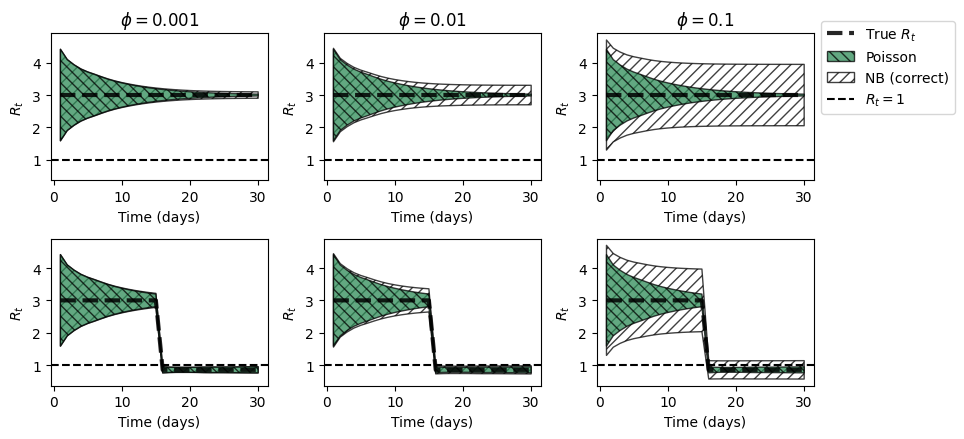

In [6]:

serial_interval = [0, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.0]
past_cases = [0] * len(serial_interval)
past_cases[-1] = 5
past_cases[-2] = 5
past_cases[-3] = 5

# One r profile constant, one step where it drops
R_profiles = []

R = [3] * 30
R_profiles.append(R)

R = [3] * 15 + [0.85] * 15
R_profiles.append(R)


cmap = matplotlib.cm.get_cmap('BrBG')

num = len(R_profiles)

phis = [0.001, 0.01, 0.1]
num_phis = len(phis)

fig = plt.figure(figsize=(3.25*num_phis, num*2.25))

for jp, phi in enumerate(phis):
    for j, R in enumerate(R_profiles):

        df = generate_case_series(R, past_cases, serial_interval, kappa=-1)
        t = list(df['day'])
        i = np.asarray(df['cases'])
        l = np.asarray(df['lambdas'])

        MLE = i / l
        var_poisson = MLE / l
        var_nb = MLE * (1 + phi * l * MLE) / l

        if jp == 0 and j ==0 :
            ax = fig.add_subplot(num, num_phis, 1 + num_phis*j + jp)
        else:
            ax = fig.add_subplot(num, num_phis, 1 + num_phis*j + jp, sharey=ax)

        ax.plot(t, R, color='k', zorder=10, label=r'True $R_t$', lw=3, ls='--', alpha=0.85)
        ax.fill_between(t, MLE - 1 * np.sqrt(var_poisson), MLE + 1 * np.sqrt(var_poisson), alpha=0.75, edgecolor='k', facecolor='seagreen', zorder=-10, hatch='\\\\\\', label='Poisson')
        ax.fill_between(t, MLE - 1 * np.sqrt(var_nb), MLE + 1 * np.sqrt(var_nb), alpha=0.75, edgecolor='k', facecolor='white', zorder=-11, hatch='///', label='NB (correct)')

        ax.axhline(1, color='k', ls='--', label='$R_t=1$', zorder=20)

        if j + 1 == 1 and jp + 1 == num_phis:
            ax.legend()
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.77))

        box = ax.get_position()
        ax.set_position(
            [box.x0, box.y0, box.width * 0.8, box.height])
        
        if j == 0:
            ax.set_title('$\phi={}$'.format(phi))
            
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('$R_t$')
    
fig.set_tight_layout(True)
plt.subplots_adjust()
plt.show()



In the plot above, the dashed lines indicate the true value of $R_t$ and the shaded regions indicate the MLE estimate of $R_t$ $\pm$ one times the Cramer Rao bound-derived standard deviation of the estimate, for the Poisson model (green) and the negative binomial model (white), and three choices of $\phi$ (overdispersion). 

### Likelihood of overdispersion

The negative binomial model is more challenging to fit to incidence data both because it lacks a conjugate prior and because it involves an additional parameter (overdispersion).

In [13]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

def likelihood(k, R, L, phi):
    return k*  np.log(phi) + k * np.log(L) + k * np.log(R) + loggamma(k+1.0/phi) -(1/phi + k)*np.log(phi*L*R+1) - loggamma(1.0/phi) - loggamma(k+1)

def full_likelihood(ks, Rs, Ls, phi):
    ll = 0
    for k, R, L in zip(ks, Rs, Ls):
        ll += likelihood(k, R, L, phi)
    return ll

cmap = cmr.get_sub_cmap('BrBG_r', 0.15, 0.99)

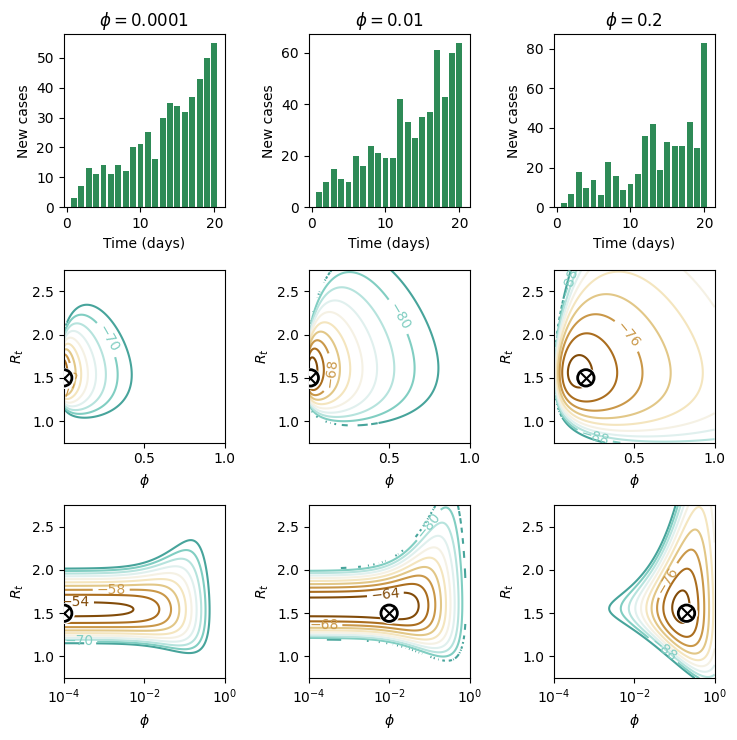

In [16]:
R = [1.5] * 20
serial_interval = [0, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.0]
past_cases = [0] * len(serial_interval)
past_cases[-1] = 10
past_cases[-2] = 10
past_cases[-3] = 10

num_runs = 1
true_phis = [0.0001, 0.01, 0.2]

fig = plt.figure(figsize=(2.5*len(true_phis), 2.5*(num_runs+2)))

for run in range(num_runs):
    for j, true_phi in enumerate(true_phis):
        df = generate_case_series(R, past_cases, serial_interval, kappa=1/true_phi)
        t = list(df['day'])
        Is = np.asarray(df['cases'])
        Ls = np.asarray(df['lambdas'])
                 
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j)
        ax.bar(t, Is, color='seagreen', alpha=1.0)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('New cases')
        ax.set_title('$\phi={}$'.format(true_phi))

        num_grid = 150
        R2 = np.linspace(0.75, 2.75, num_grid)
        if true_phi == 0.25:
            phi = np.linspace(0.0001, 1, num_grid)
        else:
            phi = np.linspace(0.0001, 1, num_grid)
            
        phi_log = np.logspace(np.log(0.0001), np.log(1), num_grid, base=np.exp(1))

        X, Y = np.meshgrid(phi, R2)
        lls = []
        for r2 in R2:
            for phii in phi:
                lls.append(full_likelihood(Is, [r2]*30, Ls, phii))

        lls = np.asarray(lls)
        lls = lls.reshape((len(R2), len(phi)))
        
        lls[lls<np.max(lls)-20] = np.nan
        
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j+len(true_phis))
        CS = ax.contour(X, Y, lls, levels=9, cmap=cmap)

        ax.set_xlabel('$\phi$')
        ax.set_ylabel('$R_t$')

        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='white', facecolors='white', s=170, linewidths=2, alpha=1)
        ax.scatter(true_phi, R[-1], zorder=10, marker='x', color='k', s=70, label='True value')
        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='k', facecolors='none', s=140, linewidths=2, label='True value')
        ax.clabel(CS, levels=[CS.levels[-2], CS.levels[-4], CS.levels[2], CS.levels[0]], inline=True, fontsize=10)


        X, Y = np.meshgrid(phi_log, R2)
        lls = []
        for r2 in R2:
            for phii in phi_log:
                lls.append(full_likelihood(Is, [r2]*30, Ls, phii))

        lls = np.asarray(lls)
        lls = lls.reshape((len(R2), len(phi_log)))
        
        lls[lls<np.max(lls)-20] = np.nan
        
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j+len(true_phis)*2)
        CS = ax.contour(X, Y, lls, levels=9, cmap=cmap)

        ax.set_xlabel('$\phi$')
        ax.set_ylabel('$R_t$')

        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='white', facecolors='white', s=170, linewidths=2, alpha=1)
        ax.scatter(true_phi, R[-1], zorder=10, marker='x', color='k', s=70, label='True value')
        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='k', facecolors='none', s=140, linewidths=2, label='True value')
        ax.set_xscale('log')
        ax.clabel(CS, levels=[CS.levels[-2], CS.levels[-4], CS.levels[2], CS.levels[0]], inline=True, fontsize=10)
                
fig.set_tight_layout(True)
plt.show()

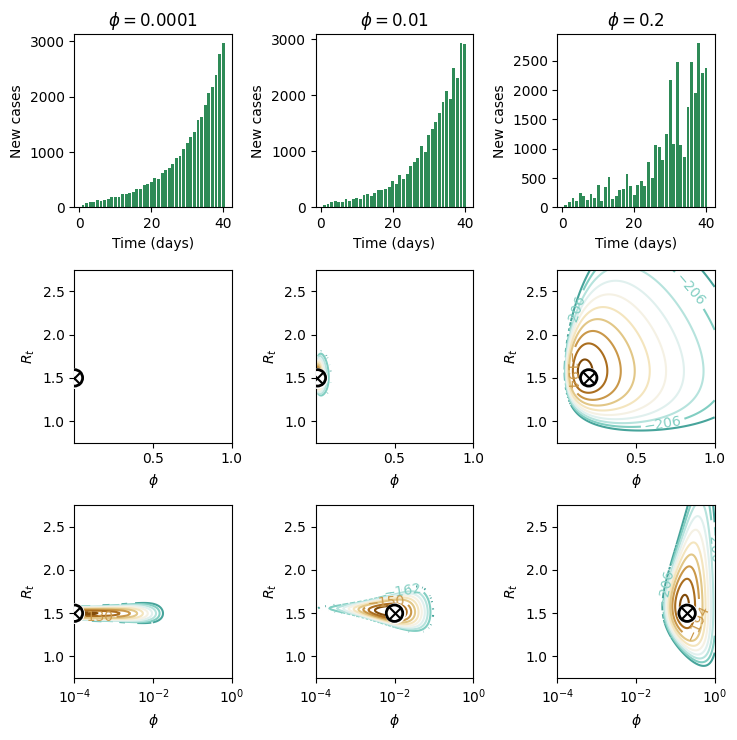

In [17]:
R = [1.5] * 40
serial_interval = [0, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.0]
past_cases = [0] * len(serial_interval)
past_cases[-1] = 100
past_cases[-2] = 100
past_cases[-3] = 100

num_runs = 1
true_phis = [0.0001, 0.01, 0.2]

fig = plt.figure(figsize=(2.5*len(true_phis), 2.5*(num_runs+2)))

for run in range(num_runs):
    for j, true_phi in enumerate(true_phis):
        df = generate_case_series(R, past_cases, serial_interval, kappa=1/true_phi)
        t = list(df['day'])
        Is = np.asarray(df['cases'])
        Ls = np.asarray(df['lambdas'])
                 
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j)
        ax.bar(t, Is, color='seagreen', alpha=1.0)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('New cases')
        ax.set_title('$\phi={}$'.format(true_phi))

        num_grid = 150
        R2 = np.linspace(0.75, 2.75, num_grid)
        if true_phi == 0.25:
            phi = np.linspace(0.0001, 1, num_grid)
        else:
            phi = np.linspace(0.0001, 1, num_grid)
            
        phi_log = np.logspace(np.log(0.0001), np.log(1), num_grid, base=np.exp(1))

        X, Y = np.meshgrid(phi, R2)
        lls = []
        for r2 in R2:
            for phii in phi:
                lls.append(full_likelihood(Is, [r2]*30, Ls, phii))

        lls = np.asarray(lls)
        lls = lls.reshape((len(R2), len(phi)))
        
        lls[lls<np.max(lls)-20] = np.nan
        
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j+len(true_phis))
        CS = ax.contour(X, Y, lls, levels=9, cmap=cmap)

        ax.set_xlabel('$\phi$')
        ax.set_ylabel('$R_t$')

        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='white', facecolors='white', s=170, linewidths=2, alpha=1)
        ax.scatter(true_phi, R[-1], zorder=10, marker='x', color='k', s=70, label='True value')
        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='k', facecolors='none', s=140, linewidths=2, label='True value')
        ax.clabel(CS, levels=[CS.levels[-2], CS.levels[-4], CS.levels[2], CS.levels[0]], inline=True, fontsize=10)


        X, Y = np.meshgrid(phi_log, R2)
        lls = []
        for r2 in R2:
            for phii in phi_log:
                lls.append(full_likelihood(Is, [r2]*30, Ls, phii))

        lls = np.asarray(lls)
        lls = lls.reshape((len(R2), len(phi_log)))
        
        lls[lls<np.max(lls)-20] = np.nan
        
        ax = fig.add_subplot(num_runs+2, len(true_phis), 1+len(true_phis)*run + j+len(true_phis)*2)
        CS = ax.contour(X, Y, lls, levels=9, cmap=cmap)

        ax.set_xlabel('$\phi$')
        ax.set_ylabel('$R_t$')

        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='white', facecolors='white', s=170, linewidths=2, alpha=1)
        ax.scatter(true_phi, R[-1], zorder=10, marker='x', color='k', s=70, label='True value')
        ax.scatter(true_phi, R[-1], zorder=10, marker='o', color='k', facecolors='none', s=140, linewidths=2, label='True value')
        ax.set_xscale('log')
        ax.clabel(CS, levels=[CS.levels[-2], CS.levels[-4], CS.levels[2], CS.levels[0]], inline=True, fontsize=10)
                
fig.set_tight_layout(True)
plt.show()

Investigate the incidence series arising from the negative binomial model compared with the time series generated by a model where each individual has their own scaling factor of the global Rt, which causes heterogeneity in the population.

In [29]:
class Person:
    def __init__(self, time):
        self.time_infected = time
        self.set_scaling_factor()
    
    def set_scaling_factor(self):
        self.scaling_factor = scipy.stats.gamma.rvs(0.1, scale=10.0)


class ABRenewalModel:
    def __init__(self, init_cases):
        self.cases = []
        for _ in range(init_cases):
            self.cases.append(Person(0))
        self.serial_interval = [0, 0.1, 0.3, 0.2, 0.2, 0.1, 0.1, 0.0]
    
    def simulate(self, Rt):
        incidence = []
        t_max = len(Rt)
        
        for t in range(t_max):
            new_cases_iter = 0
            people_to_remove = []
            
            for person in self.cases:
                if t - person.time_infected < len(self.serial_interval):
                    new_cases_iter += scipy.stats.poisson.rvs(Rt[t] * self.serial_interval[t - person.time_infected] * person.scaling_factor)    
                else:
                    people_to_remove.append(person)
            
            self.cases = [x for x in self.cases if x not in people_to_remove]
            new_cases = new_cases_iter
            
            for _ in range(new_cases):
                self.cases.append(Person(t))
                
            incidence.append(new_cases)
            
        return incidence
            
                
    

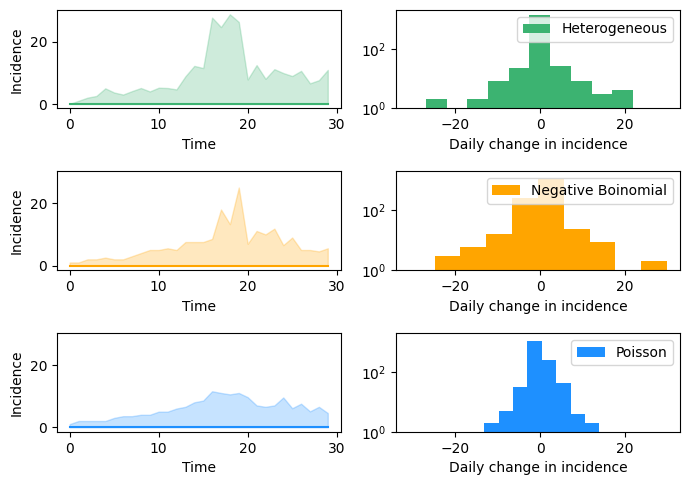

In [35]:
num_runs = 50
xs = []
diffs = []

num_init_infected = 1

for run in range(num_runs):

    m = ABRenewalModel(num_init_infected)
    Rt = [1.5] * 20 + [0.75] * 10

    x = m.simulate(Rt)
    xs.append(x)
    
    diffs += list(np.diff(x[:50]))
    
    
xs_nb = []
xs_poisson = []
diffs_nb = []
diffs_poisson = []
for run in range(num_runs):
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=5, )#kappa=1/1.53)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_nb.append(i)
    diffs_nb += list(np.diff(i[:50]))
    
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=10000)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_poisson.append(i)
    diffs_poisson += list(np.diff(i[:50]))

ts = list(range(len(Rt)))
    
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(3, 2, 1)
ax.plot(ts, np.median(xs, axis=0), color='mediumseagreen')
ax.fill_between(ts, np.percentile(xs, 5, axis=0), np.percentile(xs, 95, axis=0), alpha=0.25, color='mediumseagreen')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 3, sharey=ax)
ax.plot(ts, np.median(xs_nb, axis=0), color='orange')
ax.fill_between(ts, np.percentile(xs_nb, 5, axis=0), np.percentile(xs_nb, 95, axis=0), alpha=0.25, color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 5, sharey=ax)
ax.plot(ts, np.median(xs_poisson, axis=0), color='dodgerblue')
ax.fill_between(ts, np.percentile(xs_poisson, 5, axis=0), np.percentile(xs_poisson, 95, axis=0), alpha=0.25, color='dodgerblue')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')


bins = np.arange(-100, 300, 50)

ax = fig.add_subplot(3, 2, 2)
ax.hist(diffs, color='mediumseagreen', label='Heterogeneous')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 4, sharey=ax, sharex=ax)
ax.hist(diffs_nb, color='orange', label='Negative Boinomial')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 6, sharey=ax, sharex=ax)
ax.hist(diffs_poisson,color='dodgerblue', label='Poisson')
ax.legend()
ax.set_yscale('log')
ax.set_ylim(1, None)
ax.set_xlabel('Daily change in incidence')

fig.set_tight_layout(True)
plt.show()

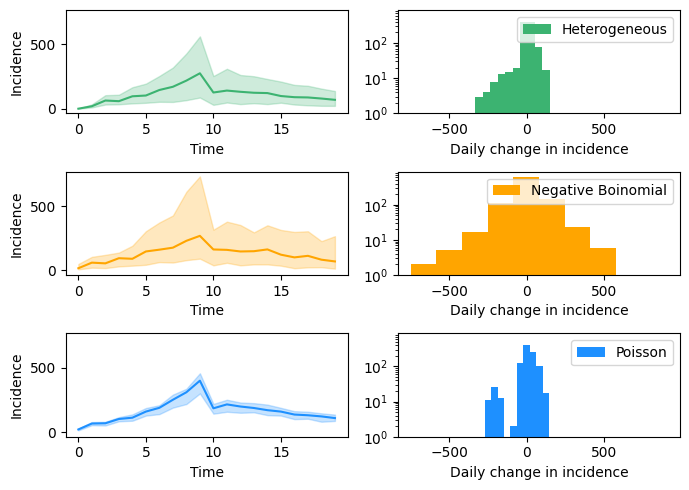

In [31]:
num_runs = 50
xs = []
diffs = []

num_init_infected = 100

for run in range(num_runs):

    m = ABRenewalModel(num_init_infected)
    Rt = [2] * 10 + [0.75] * 10

    x = m.simulate(Rt)
    xs.append(x)
    
    diffs += list(np.diff(x[:50]))
    
    
xs_nb = []
xs_poisson = []
diffs_nb = []
diffs_poisson = []
for run in range(num_runs):
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=5, )#kappa=1/1.53)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_nb.append(i)
    diffs_nb += list(np.diff(i[:50]))
    
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=10000)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_poisson.append(i)
    diffs_poisson += list(np.diff(i[:50]))

ts = list(range(len(Rt)))
    
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(3, 2, 1)
ax.plot(ts, np.median(xs, axis=0), color='mediumseagreen')
ax.fill_between(ts, np.percentile(xs, 5, axis=0), np.percentile(xs, 95, axis=0), alpha=0.25, color='mediumseagreen')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 3, sharey=ax)
ax.plot(ts, np.median(xs_nb, axis=0), color='orange')
ax.fill_between(ts, np.percentile(xs_nb, 5, axis=0), np.percentile(xs_nb, 95, axis=0), alpha=0.25, color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 5, sharey=ax)
ax.plot(ts, np.median(xs_poisson, axis=0), color='dodgerblue')
ax.fill_between(ts, np.percentile(xs_poisson, 5, axis=0), np.percentile(xs_poisson, 95, axis=0), alpha=0.25, color='dodgerblue')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')


bins = np.arange(-100, 300, 50)

ax = fig.add_subplot(3, 2, 2)
ax.hist(diffs, color='mediumseagreen', label='Heterogeneous')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 4, sharey=ax, sharex=ax)
ax.hist(diffs_nb, color='orange', label='Negative Boinomial')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 6, sharey=ax, sharex=ax)
ax.hist(diffs_poisson,color='dodgerblue', label='Poisson')
ax.legend()
ax.set_yscale('log')
ax.set_ylim(1, None)
ax.set_xlabel('Daily change in incidence')

fig.set_tight_layout(True)
plt.show()

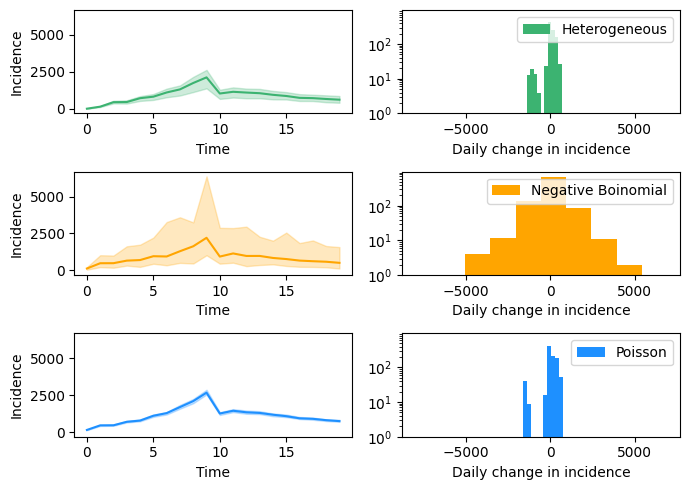

In [34]:
num_runs = 50
xs = []
diffs = []

num_init_infected = 700

for run in range(num_runs):

    m = ABRenewalModel(num_init_infected)
    Rt = [2] * 10 + [0.75] * 10

    x = m.simulate(Rt)
    xs.append(x)
    
    diffs += list(np.diff(x[:50]))
    
    
xs_nb = []
xs_poisson = []
diffs_nb = []
diffs_poisson = []
for run in range(num_runs):
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=5, )#kappa=1/1.53)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_nb.append(i)
    diffs_nb += list(np.diff(i[:50]))
    
    df = generate_case_series(Rt, [0] * (len(m.serial_interval)-2) + [num_init_infected], m.serial_interval[1:], kappa=10000)
    t = list(df['day'])
    i = np.asarray(df['cases'])
    l = np.asarray(df['lambdas'])
    xs_poisson.append(i)
    diffs_poisson += list(np.diff(i[:50]))

ts = list(range(len(Rt)))
    
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(3, 2, 1)
ax.plot(ts, np.median(xs, axis=0), color='mediumseagreen')
ax.fill_between(ts, np.percentile(xs, 5, axis=0), np.percentile(xs, 95, axis=0), alpha=0.25, color='mediumseagreen')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 3, sharey=ax)
ax.plot(ts, np.median(xs_nb, axis=0), color='orange')
ax.fill_between(ts, np.percentile(xs_nb, 5, axis=0), np.percentile(xs_nb, 95, axis=0), alpha=0.25, color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')

ax = fig.add_subplot(3, 2, 5, sharey=ax)
ax.plot(ts, np.median(xs_poisson, axis=0), color='dodgerblue')
ax.fill_between(ts, np.percentile(xs_poisson, 5, axis=0), np.percentile(xs_poisson, 95, axis=0), alpha=0.25, color='dodgerblue')
ax.set_xlabel('Time')
ax.set_ylabel('Incidence')


bins = np.arange(-100, 300, 50)

ax = fig.add_subplot(3, 2, 2)
ax.hist(diffs, color='mediumseagreen', label='Heterogeneous')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 4, sharey=ax, sharex=ax)
ax.hist(diffs_nb, color='orange', label='Negative Boinomial')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Daily change in incidence')

ax = fig.add_subplot(3, 2, 6, sharey=ax, sharex=ax)
ax.hist(diffs_poisson,color='dodgerblue', label='Poisson')
ax.legend()
ax.set_yscale('log')
ax.set_ylim(1, None)
ax.set_xlabel('Daily change in incidence')

fig.set_tight_layout(True)
plt.show()